#  Задача проекта

Необходимо построить скоринг модель для клиентов банка, предсказывающую возможность дефолта клиента. Для этого необходимо определить значимые параметры в предоставленном наборе данных и для каждого client_id предсказать вероятность для default переменной. 

## Загрузка библиотек и данных

In [1]:
#pip install pandas-profiling  # для ускорнения работы ноутбука не используем pandas-profiling, но он работает

In [2]:
from pandas import Series
import pandas as pd
import numpy as np

# import pandas_profiling
# from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve


import warnings
warnings.filterwarnings("ignore")

#Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
  # функция для построения боксплотов (распределение дефолта в признаках)

def get_boxplot(column):

    (fig, ax) = plt.subplots(figsize=(14, 4))
    sns.boxplot(x='default', y=column, data=df.loc[df.loc[:, 'default'
                ].isin(df.loc[:, 'default'].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=50)
    ax.set_title('Boxplot for ' + 'default')
    plt.show()
    
    # функция для перевода возраста в категориальную переменную
    
def age_num_cat(age):
    if age <= perc_25:
        age_cat = '0'        
    if perc_25 < age <= perc_50:
        age_cat = '1'       
    if perc_50 < age <= perc_75:
        age_cat = '2'        
    if age > perc_75:
        age_cat = '3'
    return age_cat

In [4]:
train = pd.read_csv('train(2).csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
#PATH_to_file = '/kaggle/input/sf-scoring/'
#train = pd.read_csv(PATH_to_file + 'train.csv')
#test = pd.read_csv(PATH_to_file + 'test.csv')
#sample_submission = pd.read_csv(PATH_to_file + 'sample_submission.csv')

## Предварительное исследование дата сетов и обработка.

In [6]:
# Зафиксируем размеры тренировочного и тестового датасетов:
print('Размер тренировочного датасета: ', train.shape,
      'Размер тестового датасета: ', test.shape, 
      'Размер объединенного датасета: ', train.shape[0]+test.shape[0], sep='\n')

Размер тренировочного датасета: 
(73799, 19)
Размер тестового датасета: 
(36349, 18)
Размер объединенного датасета: 
110148


In [7]:
# посмотрим на представленныe датасетs:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [8]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [9]:
# В тестовом дата сете отсутствует целевая переменная переменная default,
# при объединении дата сетов добавляем столбец train для возможности разделения сетов на первоначальные  наборы данных:

train['train'] = 1 # помечаем тренировочные
test['train'] = 0 # помечаем тестовые
df = pd.concat([train, test], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

### Описание полей сета

     Наименование поля                         Описание поля 
     __________________________________________________________________________________
     
     client_id                                 идентификатор клиента
     
     app_date                                  дата подачи заявки
     
     education                                 уровень образования
     
     sex                                       пол заемщика
     
     age                                       возраст заемщика
     
     car                                       флаг наличие автомобиля
     
     car_type                                  флаг автомобиля иномарки
     
     decline_app_cnt                           количество отказанных заявок в прошлом
     
     good_work                                 флаг наличие "хорошей" работы
     
     score_bki                                 скоринговый балл по данным из БКИ
     
     bki_request_cnt                           количество запросов в БКИ
     
     region_rating                             рейтинг региона
   
     home_address                              категоризатор домашнего адресаа
     
     work_address                              категоризатор раьочего адреса
      
     income                                    доход заемщика
     
     sna                                       связь заемщика с клиентами банка
     
     first_time                                давность наличия информации о заемщике
     
     foreign_passport                          наличие загранпаспорта
     
     default                                   наличиле дефолта (целевая переменная)
     _______________________________________________________________________________________

Наш датасет содержит 19 признаков, в т.ч.:

    7 числовых
    6 категориальных
    5 бинарных (*)
    1 временной
    Целевая переменная - default.   
    
(*) Несмотря на то, что ProfileReport отнес sex к категориальным признакам, значение у него только два, поэтому мы относим его к бинарным.

##### Для получения статистики по признакам воспользуемся модулем pandas_profiling.

In [10]:
# df_profile_report = ProfileReport(df, title='Train report')

# df_profile_report
# Профайлером пользовадась на kaggle,  на юпитере тоже работает, но почему-то не выводит все остальные графики,
# поэтому в ноутбуке им не пользуемся, но выводы сделаны на его основе.

Выводы:

Наш исходный  датасет содержит 18 признаков и 1 целевую переменную. Признак 'train' введен нам для определения трейновой и тестовой частей, поэтому статистика по нему нас не интересует, также тестовая часть не содержит значения целевой переменной, но на построение модели это не повлияет, поэтому заполнять её нулями не будем.

Дата сет содержит пропуски только в столбце education, но их менее 1% (478) поэтому заполнять их мы будем модой.

Встречается высокая кореляция между некоторыми парами признаков, а именно: наличие авто (car) и наличие иномарки (car_type) - прямая; домашний адрес (home_address) и рабочий адрес (work_address) -прямая, связь клиента с банком(sna) и  давность наличия информации о заемщике(first_time)- обратная. Посмотрим в дальнейшем , что можно с этим сделать. 

Касательно возраста и пола заемщиков, то женщин среди заемщиков больше , но не намного (56,1%), срединий возраст около 39-40 лет. Самому молодому клиенту 21, самый возрастной - 72, здесь выбросов на первый взгляд нет. Но возможно для дальшейшей работиы постребуется перевод этого призгнака в категоральный, поскольку в таком виде он практически не оказывает влияния на целевую переменную.

У большинства заемщиков нет машины (67,4%), отсутствует хорошая работа (83,4%) и загранпаспорт (85%). 

Около четверти клинентов в банк не обращались и соответственно не имеют отказанных заявок в прошлом, так же около 25 % клиентов обращались в банк впервые и возможно не также не имеют отказов. Вообще 83% клиентов не имеют отказов в прошлом, но отказы все же встречются,максимальное значение отклоненных заявок достигает 33. Распределение признака смещено вправо.

Из всех чиловых признаков, только скоринговый бал имеет нормальное распределение и скорее всего не нуждается в дополнительных операциях. Доход же можно приблизить к нормальному возможно лорифмированием.

Также присутствуют такие признаки, как рейтинг региона, связь клиента с банком и давность наличия информации о заемщике. Все они категориальные. В рейтинге региона к двум первым категориям относится меньше 1 % клиентов, возможно он потребует укрупнения. Остальные два признака имеют по четыре категории. Для sna (1)- это скорее всего наименьшая связь клиента с банком, поскольку к ней относятся более 60%, а по обращениями в бки 50% клиентов в банк не обращалась вообще или одращалась только один раз, но это только догадки.

Также имеется один временной признак, с которого мы и начнем работать с нашим датасетом.

### Подработка признаков и дальнейшее их распределение по категорям.


Признак client_id имеет равномерное распределение, содержит только уникальные значения - индентификационные номера клиентов, поэтому оказывать влияние на модель данный признак не будет и в дальнейшей работе он не будет учитываться.

#### app_date

Это единственный временнорй признак, он требует преобразования в другой формат. На его основе созданим несколько новых признаков, из которых в последствии выберем наимее коррелирующиеся между собой.

In [11]:
# преобразуем признак в формат даты:
df['app_date'] = pd.to_datetime(df['app_date'])

# Посмотри на размер периода наблюдений:
display(f'Начало наблюдений: {df.app_date.min()}', f'Конец наблюдений: {df.app_date.max()}')


'Начало наблюдений: 2014-01-01 00:00:00'

'Конец наблюдений: 2014-04-30 00:00:00'

Ясно, что наблюдения велись только в 2014, поэтому для дальшейшей работы будем использовать день, месяц и день недели:

In [12]:
df['app_day'] = df.app_date.dt.day
df['app_month'] = df.app_date.dt.month
df['app_weekday'] = df.app_date.dt.weekday

In [13]:
# также можно сделать столбец с периодом в днях, прошедших от начала наблюдений до текущей:
df['delta_days'] = (df.app_date - df.app_date.min()).dt.days
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,train,app_day,app_month,app_weekday,delta_days
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,...,18000,4,1,N,0.0,1,1,2,5,31
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,...,19000,4,1,N,0.0,1,12,3,2,70
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,...,30000,1,4,Y,0.0,1,1,2,5,31
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,...,10000,1,3,N,0.0,1,23,1,3,22
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,...,30000,1,4,Y,0.0,1,18,4,4,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,2014-03-31,SCH,F,37,N,N,1,0,-1.744976,...,15000,4,1,N,NaN,0,31,3,0,89
110144,106254,2014-04-25,GRD,F,64,Y,Y,0,0,-2.293781,...,200000,1,4,N,NaN,0,25,4,4,114
110145,81852,2014-03-30,GRD,M,31,N,N,2,0,-0.940752,...,60000,4,2,N,NaN,0,30,3,6,88
110146,1971,2014-01-07,UGR,F,27,N,N,1,0,-1.242392,...,30000,1,1,N,NaN,0,7,1,1,6


<AxesSubplot:>

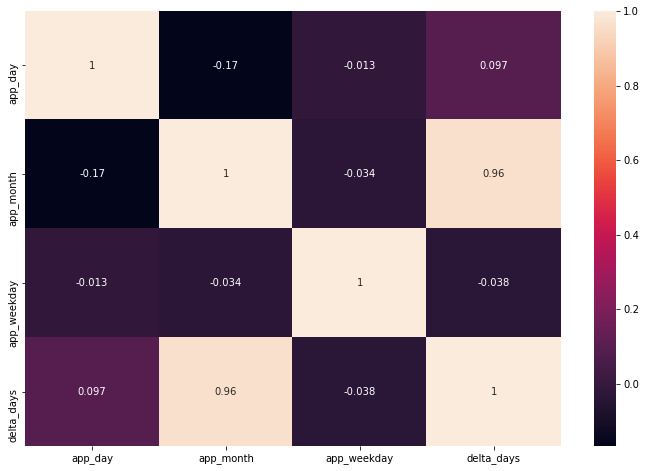

In [14]:
# Проверим новые временные признаки на корреляцию:
plt.figure(figsize=(12,8))
sns.heatmap(df.iloc[:,20:].corr(), annot=True)

In [15]:
# Месяц и период в днях сильно коррерируют между собой, один их них нужно исключить. 
# Уберем месяц, а заоодно избавимся от app_date:
df = df.drop(['app_month', 'app_date'], axis = 1)

#### education

Это единственный признак (категориальный), где есть пропуски -478, что составляет менее 1%. Заполним их модой. Затем заменим буквенные сокращения на числовые от 0 до 4 согласно распределения

In [16]:
df['education'] = df['education'].fillna(df['education'].mode()[0]) # заполняем пропуски модой
df.education.isna().sum() # проверяем столбец на пропуски

0

In [17]:
# С помощью LabelEncoder преобразуем буквенные значения в числовые:
label_encoder = LabelEncoder()

df['education'] = label_encoder.fit_transform(df['education'])
print(dict(enumerate(label_encoder.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


In [18]:
df.sample(10)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,train,app_day,app_weekday,delta_days
51439,68948,1,M,38,Y,Y,0,0,-1.672742,2,...,2,120000,2,2,N,0.0,1,17,0,75
76498,83774,3,M,44,Y,Y,0,0,-1.724278,2,...,3,75000,2,3,N,NaN,0,31,0,89
83403,47740,3,M,42,N,N,0,0,-2.059635,3,...,3,35000,1,3,N,NaN,0,24,0,54
23223,66277,1,F,21,N,N,0,0,-1.235445,1,...,3,17000,1,2,Y,0.0,1,15,5,73
64067,27627,3,F,44,Y,N,0,0,-1.830485,0,...,1,55000,2,3,N,0.0,1,3,0,33
105077,38966,3,F,44,Y,N,0,1,-1.239459,0,...,2,20000,1,2,N,NaN,0,15,5,45
51160,56765,3,F,46,Y,Y,0,1,-2.640402,2,...,3,28000,4,1,N,0.0,1,5,2,63
69519,15650,1,F,40,N,N,0,0,-1.743880,5,...,2,58000,2,3,N,1.0,1,22,2,21
29191,6798,3,F,41,N,N,0,0,-2.439872,4,...,1,10000,4,2,N,0.0,1,14,1,13
12320,51696,1,F,35,N,N,0,0,-1.288465,4,...,3,80000,4,1,N,0.0,1,28,4,58


### Списки признаков по категориям
Создадим три списка признаков: бинарные, категориальные и числовые

In [19]:
# бинарные 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna','first_time', 'app_weekday']

# числовые 
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt','income', 'app_day', 'delta_days']

In [20]:
# ибзбавимся от буквенных значений в бинаргых признака:
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])  

В признаке пол клиента (sex) 1- соответствует мужчине, 0 - женщине; наличие загранпаспорта (foreign_passport) -1, отсутствие -0; наличие автомобиля (car) -1, отсутствие -0. В признаке car_type 1-наличие авто иномарки, однако 0 - не означает наличие отечественного авто, поскольку в признаке car 67,4% клиентов не имеют автомобиля вообще. Необходимо откорректировать эти признаки. Можно на основе этих признаков создать новый, учитывающий три составляющие: наличие авто иномарки, наличие отечественного авто, отсутствие авто.

In [21]:
df['car_new'] = df[['car', 'car_type']].apply(
    lambda x: -1 if x[0] == x[1] == 0 else x[1], axis=1)
df['car_new'] = df['car_new'].replace({-1: 'car_no', 0: 'car_dom', 1: 'car_for'})
df = pd.concat([df,pd.get_dummies(df.car_new)],axis=1)
bin_cols.remove('car') # удаляем признаки изсписка бинарных переменных
bin_cols.remove('car_type')
bin_cols.extend(['car_for', 'car_dom','car_no']) # добавляем новые признаки в список с бинарными переменными

In [22]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,foreign_passport,default,train,app_day,app_weekday,delta_days,car_new,car_dom,car_for,car_no
0,25905,3,1,62,1,1,0,0,-2.008753,1,...,0,0.0,1,1,5,31,car_for,0,1,0
1,63161,3,0,59,0,0,0,0,-1.532276,3,...,0,0.0,1,12,2,70,car_no,0,0,1
2,25887,3,1,25,1,0,2,0,-1.408142,1,...,1,0.0,1,1,5,31,car_dom,1,0,0
3,16222,3,0,53,0,0,0,0,-2.057471,2,...,0,0.0,1,23,3,22,car_no,0,0,1
4,101655,1,1,48,0,0,0,1,-1.244723,1,...,1,0.0,1,18,4,107,car_no,0,0,1


In [23]:
# посмотрим на списки полученных признаков после первичных преобразований:
print(bin_cols)
print(cat_cols)
print(num_cols)

['sex', 'good_work', 'foreign_passport', 'car_for', 'car_dom', 'car_no']
['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'app_weekday']
['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'app_day', 'delta_days']


##### Оценка важности  бинарных и категориальных признаков на целевую переменную default

<AxesSubplot:>

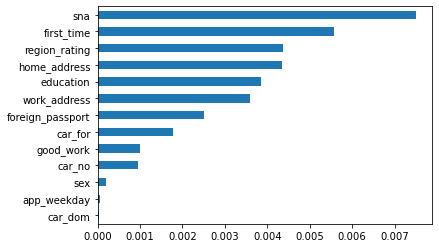

In [24]:
imp_cat = Series(mutual_info_classif(df[df['train'] == 1][bin_cols + cat_cols], df[df['train'] == 1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самым значимым из не числовых признаков является наличие у клиента связей в банке, самым незначительным - наличие у клиента отечественного авто. Для построения первой (наивной) модели пока оставим все как есть.

##### Оценка важности числовых признаков на целевую переменную default

<AxesSubplot:>

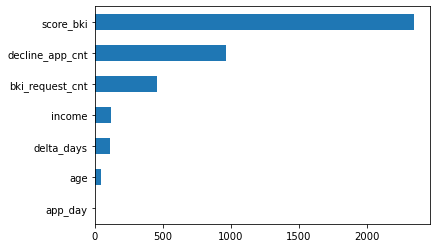

In [25]:
imp_num = pd.Series(f_classif(df[df['train'] == 1][num_cols], df[df['train'] == 1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Из числовых признаков самый влиятельный - скоринговый балл по данным из БКИ, что и понятно, а наименее влияющим  на принятие решения - день месяца выдачи кредита. Также пока ничего больше не меняем для построения модели.  

## Первая (почти наивная) модель

In [26]:
# Временно поделим наш датасет обратно - на трейнировочный и тестовый.
train_ = df.query('train == 1').drop(['train','client_id', 'car', 'car_type', 'car_new'], axis=1)
test_ = df.query('train == 0').drop(['train','client_id', 'car', 'car_type', 'car_new'], axis=1)

X = train_.drop(['default'], axis=1).values
Y = train_['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [27]:
model_0 = LogisticRegression(max_iter = 1000)
model_0.fit(X_train, y_train)
y_pred = model_0.predict(X_test)

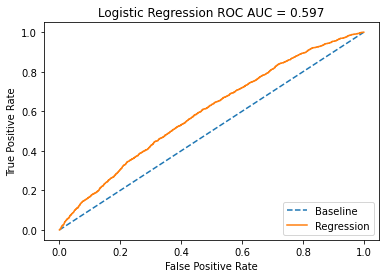

In [28]:
probs = model_0.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [29]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 3)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 3)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 3)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 3)))

accuracy_score: 0.876
f1_score: 0.0
recall_score: 0.0
MSE: 0.124


<AxesSubplot:>

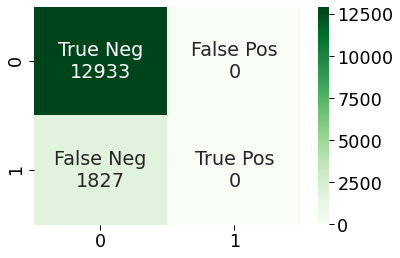

In [30]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Greens')

In [31]:
# Построим матрицу ошибок
confusion_matrix(y_test, y_pred)

array([[12933,     0],
       [ 1827,     0]], dtype=int64)

Наша наивная модель совсем не находит клиентов, которым грозит дефолт, т.е. наша модель выдает кредиты всем подряд. Значения recall(полноты) и соответственно f1 (классификация ошибок метрик) равны нулю, что никуда не годиться. 

## Почти наивая модель со стандартизацией числовых признаков.

Добавим к наивной модели стандартизацию числовых признаков и преобразование категориальных переменных с помощью метода One Hot Encoding.

In [32]:
train = df.query('train == 1').drop(['train'], axis=1)
test = df.query('train == 0').drop(['train'], axis=1)
# стандартизируем числовые переменные:
X_num = StandardScaler().fit_transform(train[num_cols].values)

In [33]:
# Выводим категориальные переменные в 0 или 1.
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)

In [34]:
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [36]:
model_1 = LogisticRegression(solver = 'liblinear', max_iter = 1000)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)

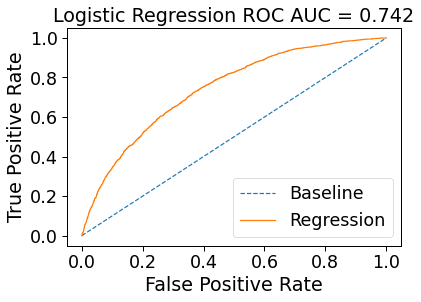

In [37]:
probs = model_1.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [38]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 3)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 3)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 3)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 3)))

accuracy_score: 0.874
f1_score: 0.04
recall_score: 0.021
MSE: 0.126


<AxesSubplot:>

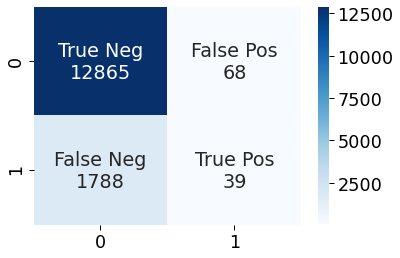

In [39]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

In [40]:
# Построим матрицу ошибок
confusion_matrix(y_test, y_pred)

array([[12865,    68],
       [ 1788,    39]], dtype=int64)

Наша модель лучше начальной, поскольку она уже определяет верно небольшое количество дефолтных клиентов, однако этого недостаточно, да и основные метрики не превышают 4% (recall и f1). Accuracy в нашем случае не нужно принимать в расчет, поскольку у большинства клиентов не имеют риска дефолта, и этот показатем не будет меньше 87%, даже если наша модель не нафжет не одного дефолта (см.наивную модель). Значит в обучающей выборке 87% - дефолт 0.

### Числовые признаки

<AxesSubplot:>

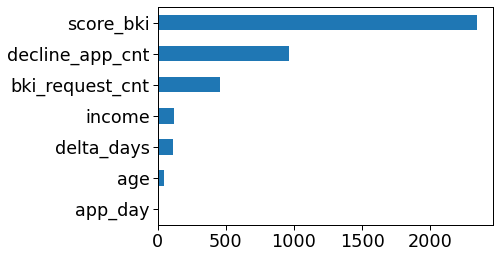

In [41]:
# Продолжим изучать признаки, еще раз проверим числовые признаки на значимость.

temp_df = df[df['train'] == 1]
imp_num = Series(f_classif(temp_df[num_cols], temp_df['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Также построим боксплоты и определим признаки, которые имеют выбросы, а также те признаки, которые не сильно изменяются для дефолтных и недефолтных клиентов.

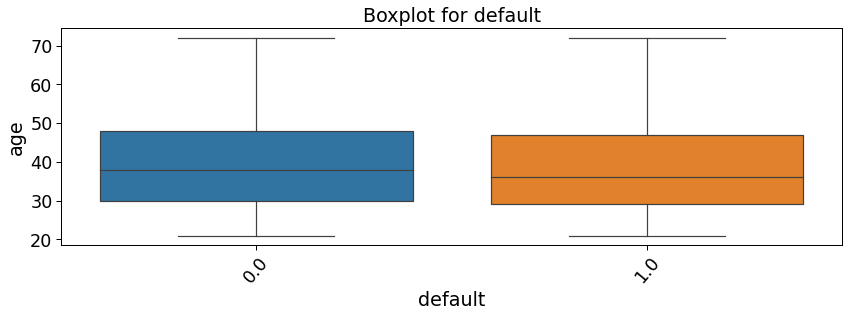

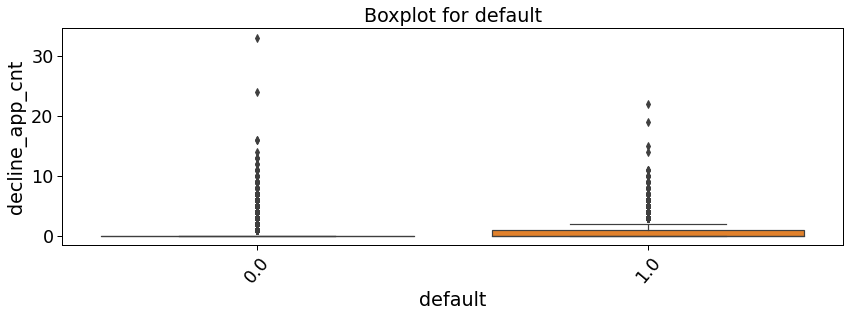

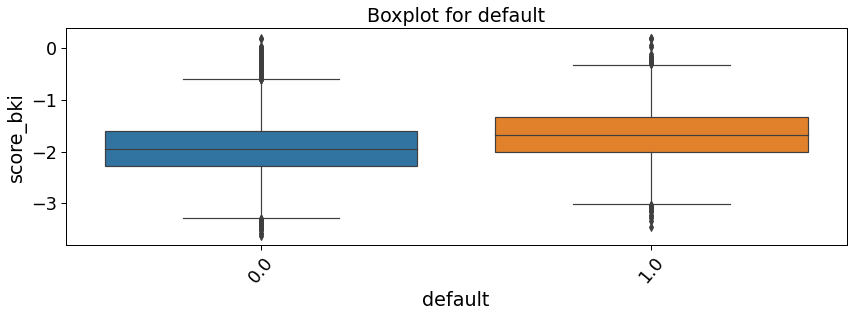

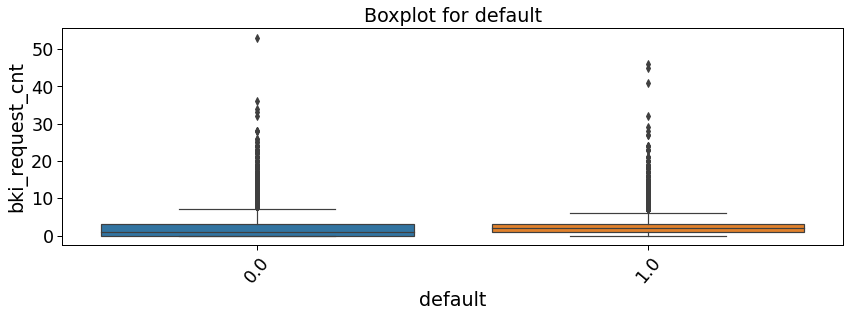

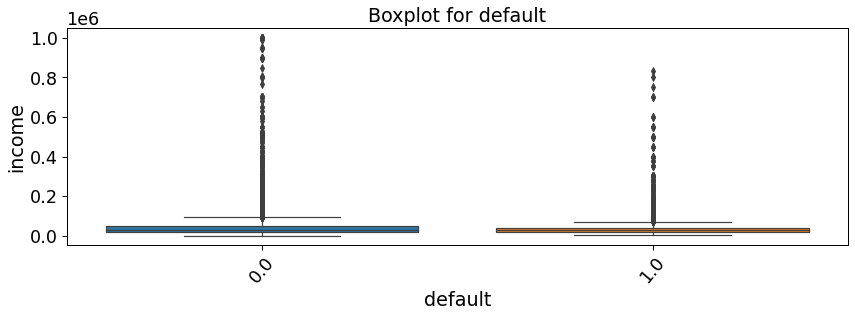

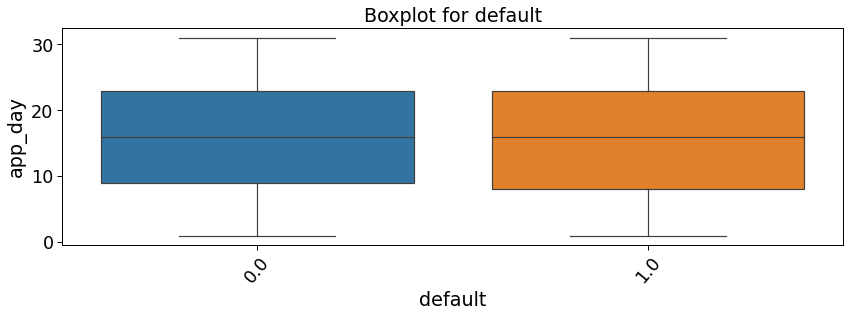

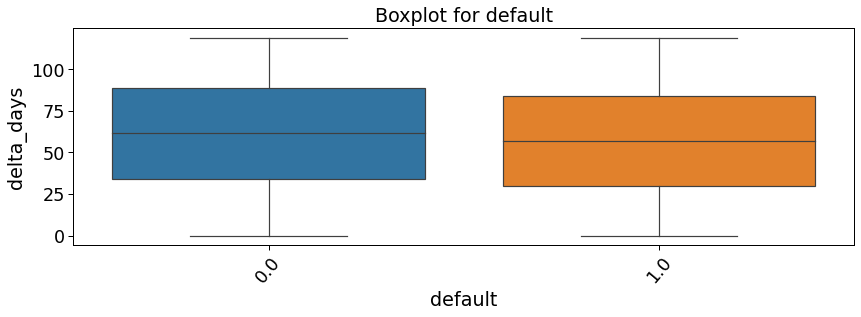

In [42]:
for column in num_cols:
    get_boxplot(column)

День месяца практически не влияет на дефолт и по значимости числовых признаков он на последнейм месте. Будем от него избавляться и уберем его из нашего списка числовых признаков.

In [43]:
df.drop(['app_day'], axis=1, inplace=True)
num_cols.remove('app_day')

Попробуем перевести возраст в категориальный признак. Для этого разделим его по процентилям и применим функцию age_num_cat. 

In [44]:
perc_25 = df.age.quantile(0.25)
perc_50 = df.age.quantile(0.5)
perc_75 = df.age.quantile(0.75)

In [45]:
# создадим новый признак - возраст категориальный (age_cat):
df['age_cat'] = df['age'].apply(lambda x:age_num_cat(x))
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,foreign_passport,default,train,app_weekday,delta_days,car_new,car_dom,car_for,car_no,age_cat
0,25905,3,1,62,1,1,0,0,-2.008753,1,...,0,0.0,1,5,31,car_for,0,1,0,3
1,63161,3,0,59,0,0,0,0,-1.532276,3,...,0,0.0,1,2,70,car_no,0,0,1,3
2,25887,3,1,25,1,0,2,0,-1.408142,1,...,1,0.0,1,5,31,car_dom,1,0,0,0
3,16222,3,0,53,0,0,0,0,-2.057471,2,...,0,0.0,1,3,22,car_no,0,0,1,3
4,101655,1,1,48,0,0,0,1,-1.244723,1,...,1,0.0,1,4,107,car_no,0,0,1,2


In [46]:
# теперь можно избавиться от числового возраста: 
df = df.drop('age',axis=1)

In [47]:
#Количество обращений в банк более 7 раз имеют  сравнительно небольшой процент клиентов (менее 6%):
df[df.bki_request_cnt < 6].bki_request_cnt.value_counts().sum()/df.bki_request_cnt.count()

0.9416421541925409

In [48]:
#Переведем этот признак в категориальный:
df.bki_request_cnt = df.bki_request_cnt.apply(lambda x: 6 if x >= 6 else x)
df.sample(10)

,client_id,education,sex,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,foreign_passport,default,train,app_weekday,delta_days,car_new,car_dom,car_for,car_no,age_cat
84944,14174,3,1,1,0,0,0,-2.356188,1,60,...,0,NaN,0,1,20,car_dom,1,0,0,2
63452,19564,3,0,0,0,0,0,-1.913383,2,50,...,0,0.0,1,0,26,car_no,0,0,1,3
78707,92364,3,0,1,1,0,0,-2.668791,4,60,...,0,NaN,0,1,97,car_for,0,1,0,2
36280,54237,3,0,1,1,0,0,-1.001358,3,50,...,0,0.0,1,0,61,car_for,0,1,0,0
52218,76003,3,0,0,0,0,1,-2.243510,2,50,...,0,0.0,1,0,82,car_no,0,0,1,3
5953,89159,4,0,0,0,1,0,-1.439189,1,50,...,0,1.0,1,5,94,car_no,0,0,1,3
26478,67480,1,1,0,0,3,0,-0.751709,0,80,...,0,0.0,1,6,74,car_no,0,0,1,1
109450,30364,3,0,0,0,0,0,-1.466024,2,50,...,0,NaN,0,3,36,car_no,0,0,1,1
68987,85732,3,0,1,1,0,0,-2.457599,1,80,...,0,0.0,1,2,91,car_for,0,1,0,3
79239,47560,1,0,0,0,0,0,-1.781419,5,50,...,0,NaN,0,0,54,car_no,0,0,1,3


In [49]:
# Аналогичная ситуация с количеством отказов в прошлом:
df[df.decline_app_cnt < 3].bki_request_cnt.value_counts().sum()/df.bki_request_cnt.count()

0.9768039365217707

In [50]:
df.decline_app_cnt = df.decline_app_cnt.apply(lambda x: (x if x < 3 else 3))

In [51]:
df.head()

,client_id,education,sex,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,foreign_passport,default,train,app_weekday,delta_days,car_new,car_dom,car_for,car_no,age_cat
0,25905,3,1,1,1,0,0,-2.008753,1,50,...,0,0.0,1,5,31,car_for,0,1,0,3
1,63161,3,0,0,0,0,0,-1.532276,3,50,...,0,0.0,1,2,70,car_no,0,0,1,3
2,25887,3,1,1,0,2,0,-1.408142,1,80,...,1,0.0,1,5,31,car_dom,1,0,0,0
3,16222,3,0,0,0,0,0,-2.057471,2,50,...,0,0.0,1,3,22,car_no,0,0,1,3
4,101655,1,1,0,0,0,1,-1.244723,1,60,...,1,0.0,1,4,107,car_no,0,0,1,2


In [52]:
# Сделаем уточнения в списках:

num_cols.remove('age')
num_cols.remove('bki_request_cnt')
num_cols.remove('decline_app_cnt')
cat_cols.append('age_cat')
cat_cols.append('bki_request_cnt')
cat_cols.append('decline_app_cnt')

In [53]:
print(num_cols)
print(cat_cols)

['score_bki', 'income', 'delta_days']
['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'app_weekday', 'age_cat', 'bki_request_cnt', 'decline_app_cnt']


<AxesSubplot:>

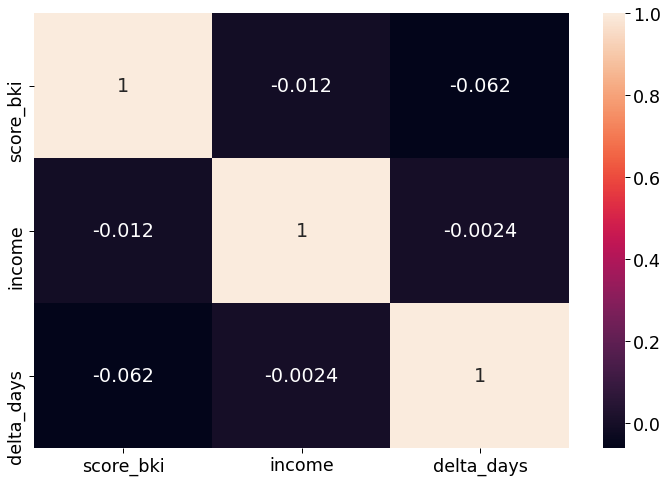

In [54]:
# посмотрим на коррелицию чичловых признаков:
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols].corr(), annot=True)

Числовые признаки практически не свяимосвязаны друг с другом. Теперь посмотрим на распеределение оставшихся числовых признаков: 

Числовой признак"score_bki":
count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64


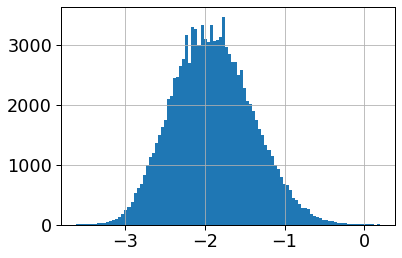

Числовой признак"income":
count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


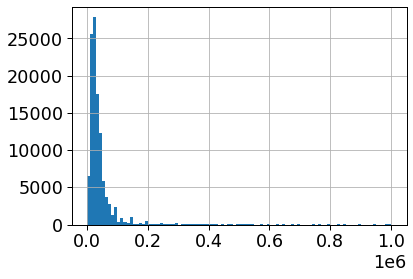

Числовой признак"delta_days":
count    110148.000000
mean         60.971466
std          32.076078
min           0.000000
25%          33.000000
50%          62.000000
75%          89.000000
max         119.000000
Name: delta_days, dtype: float64


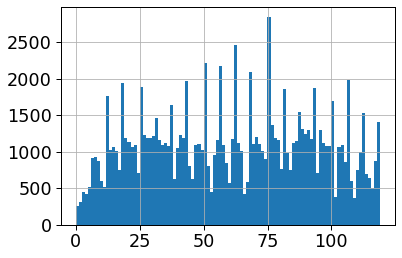

In [55]:
# Поглядим на распределение числовых признаков:

for col in num_cols:
    print('Числовой признак"{a}":'.format(a=col)) # выводим название переменной
    print(df[col].describe())
    # выводим распределение заемщиков по признакам
    df[col].hist(bins=100)
    plt.show()

Признаки можно прологарифмировать, чтобы добиться более нормального распределения. Не логарифмирует только банковский скоринг клиента, у него и так нормальное распределение.

In [56]:
# Прологарифмируем доход и разницу в днях.
num_cols_log = ['delta_days', 'income']
for col in num_cols_log:
    df[col] = np.log(df[column]+3)

Логарифмированный признак"delta_days":


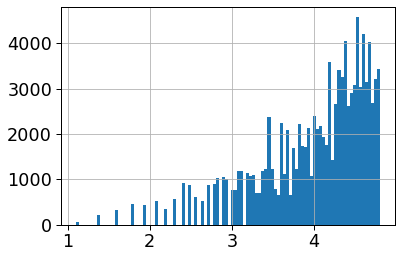

Логарифмированный признак"income":


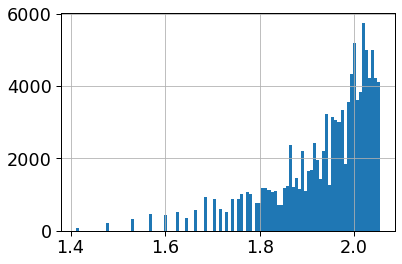

In [57]:
for col in num_cols_log:
    print('Логарифмированный признак"{a}":'.format(a=col)) # выводим название переменной
    df[col].hist(bins=100)
    plt.show()

In [58]:
# Добавим новые полиномиальные признаки.
pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(df[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
df = df.join(poly_df, how='left')

In [59]:
df.sample()

,client_id,education,sex,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,car_dom,car_for,car_no,age_cat,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
31019,26186,2,0,0,0,0,0,-1.020206,2,80,...,0,0,1,0,1.04082,-1.918274,-3.627187,3.535457,6.685054,12.6405


Закончим на этом преобразовыввать числовые признаки.

### Бинарные признаки

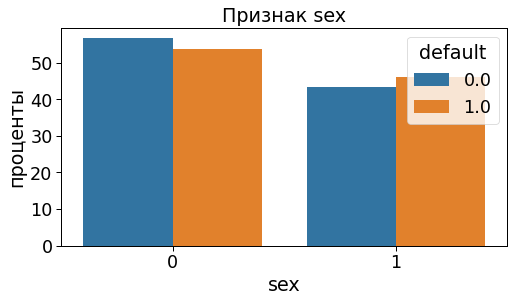

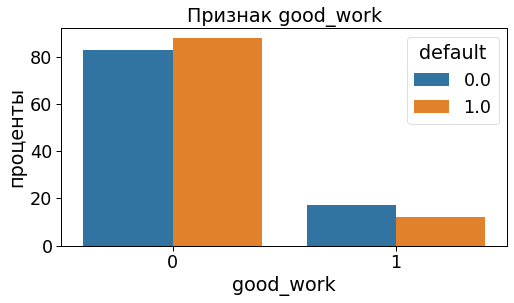

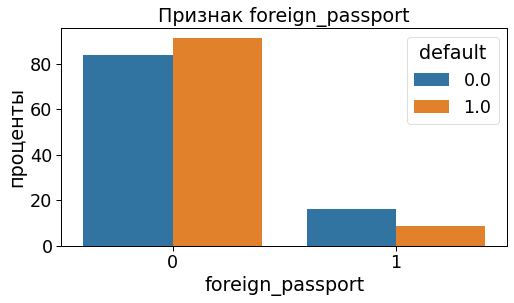

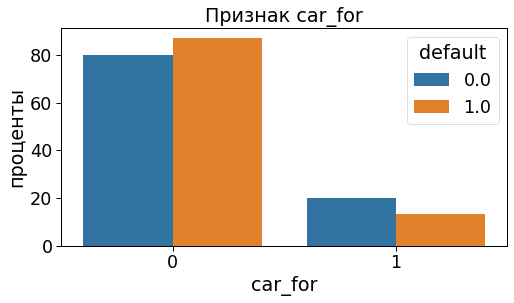

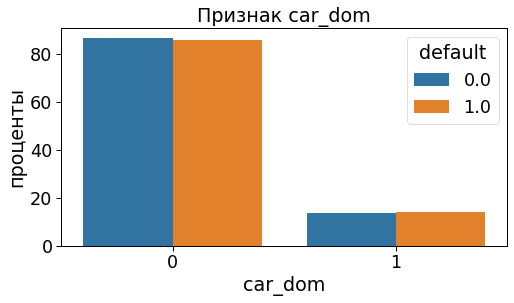

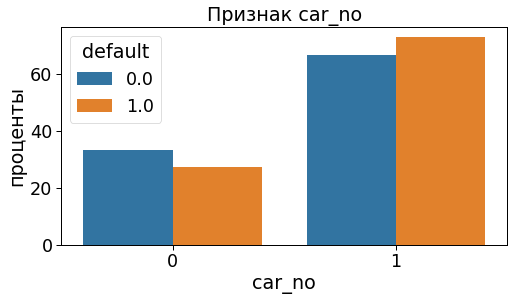

In [60]:
# Построим графики распределения значений по их соотношению с default:
for col in bin_cols:
    plt.figure(figsize=(8, 4))
    prop_df = df[col].groupby(df["default"]).value_counts(
        normalize=True).rename("проценты").reset_index()
    prop_df["проценты"] *= 100
    sns.barplot(x=col, y="проценты", hue="default", data=prop_df)
    plt.title(f"Признак {col}")

Женщины чаще обращаются в банк, но дефортов больше у мужчин. Также больше дефолтов у людей без машины, загранпаспорта и хорошей работы. Наличие или отсутствие отечественного авто правктически на дефолт не влияет, но пока избавляться от него не будем.

<AxesSubplot:>

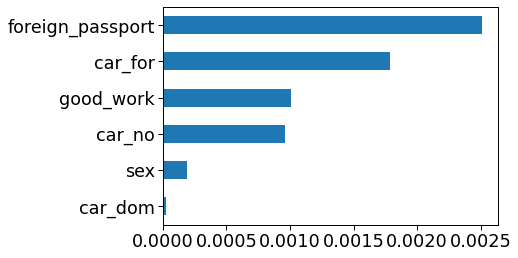

In [61]:
# Поскольку в 0 и 1 мы их уже перевели, осталось только проверить значимость бинарных переменных:
temp_df = df[df['train'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[bin_cols],
                 temp_df['default'], discrete_features=True),
                 index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Самые значимые признаки - наличие загранпаспорта и иномарки, наименьший по значимости - наличие отечественного авто, что мы уже отмечали.

<AxesSubplot:>

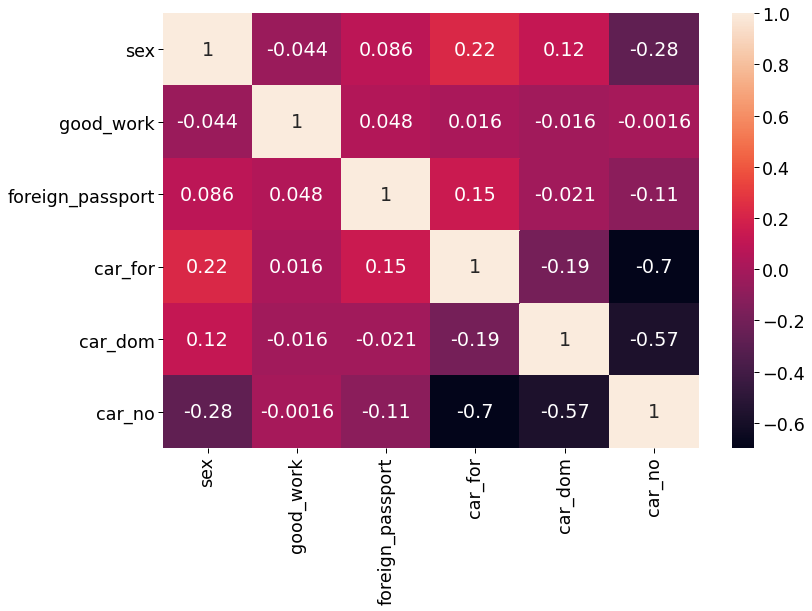

In [62]:
# Построим матрицу корреляций для бинарных признаков:
plt.figure(figsize=(12,8))
sns.heatmap(df[bin_cols].corr(), annot=True)

Автомобильные признаки сохраняют высокую корреляцию, но пока не будем их удалять.

## Категориальные признаки

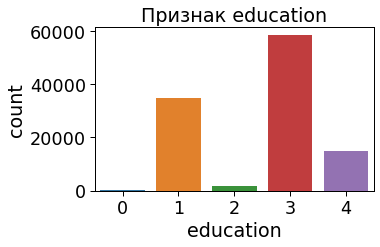

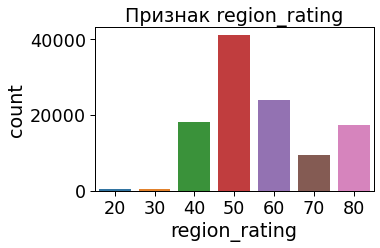

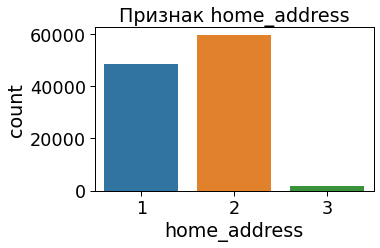

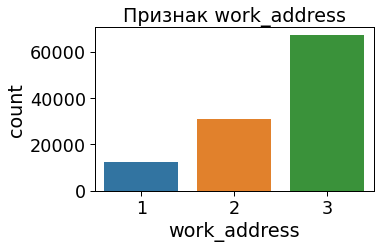

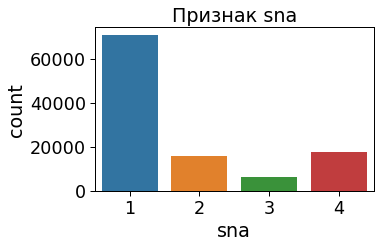

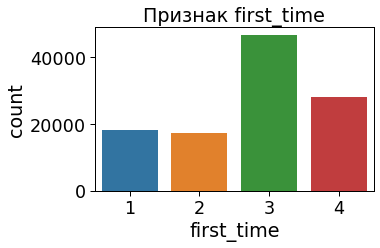

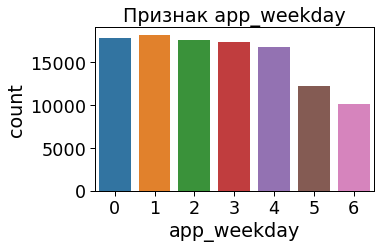

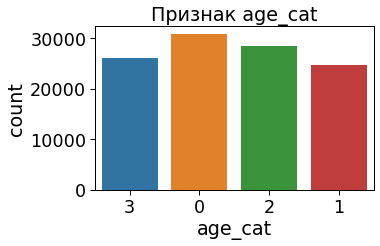

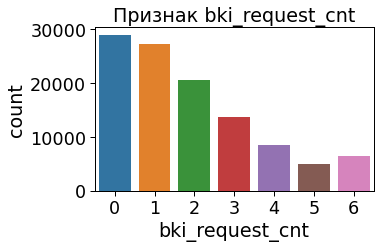

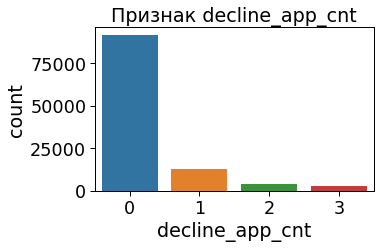

In [63]:
# Построим графики распределения значений по их количеству:
for col in cat_cols:
    plt.figure(figsize=(5, 3))
    sns.countplot(df[col])
    plt.title(f"Признак {col}")

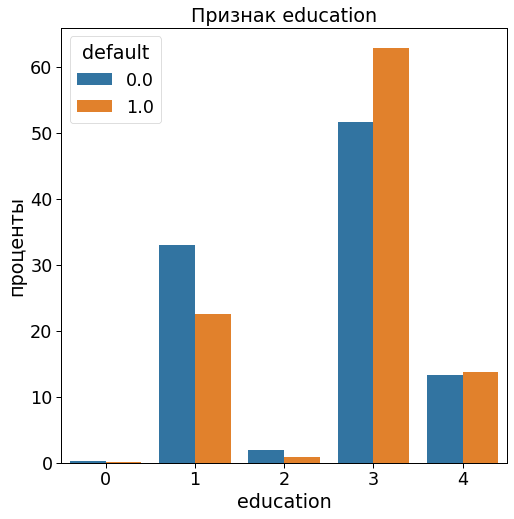

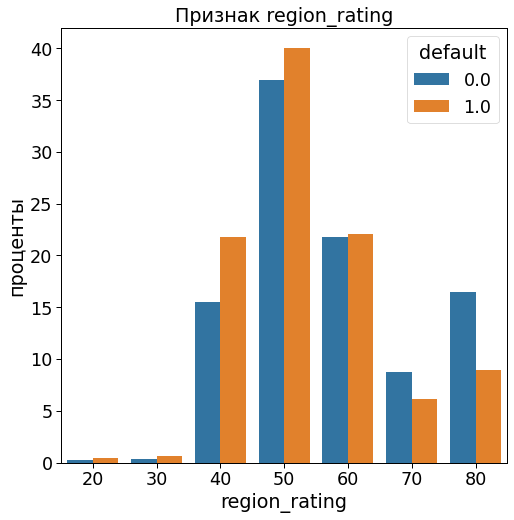

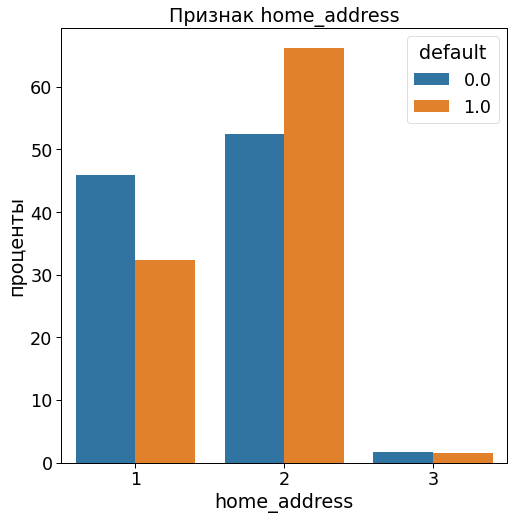

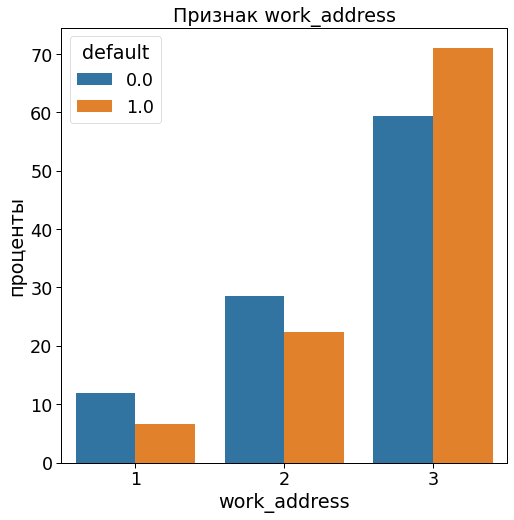

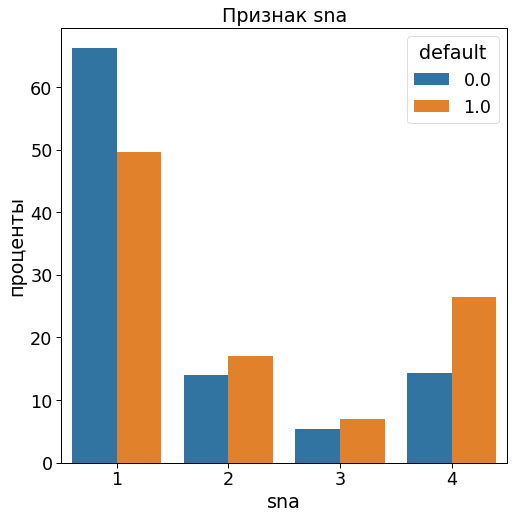

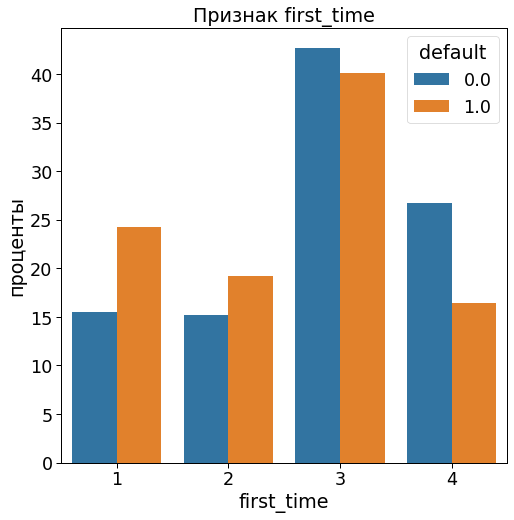

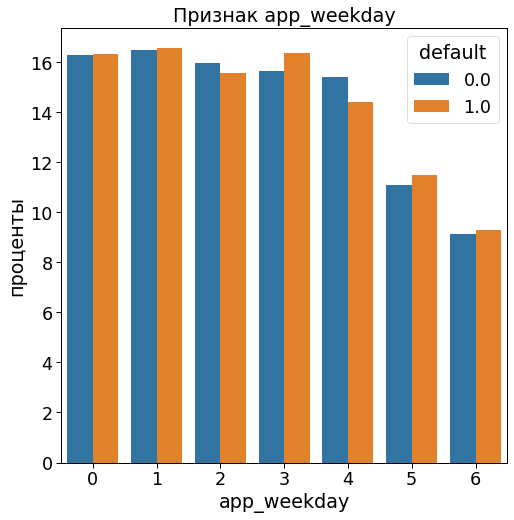

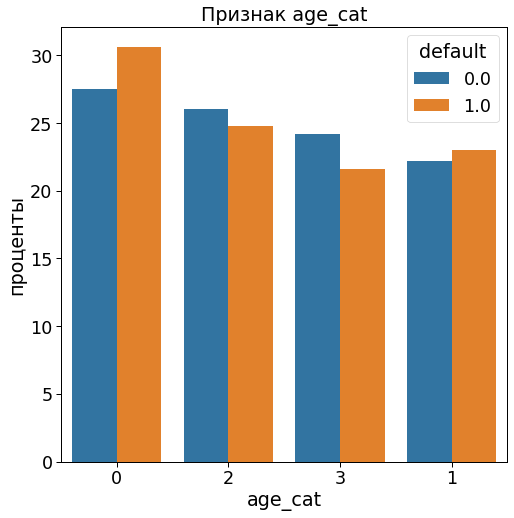

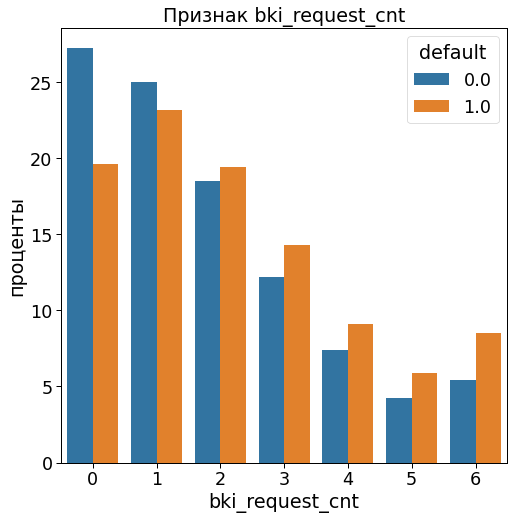

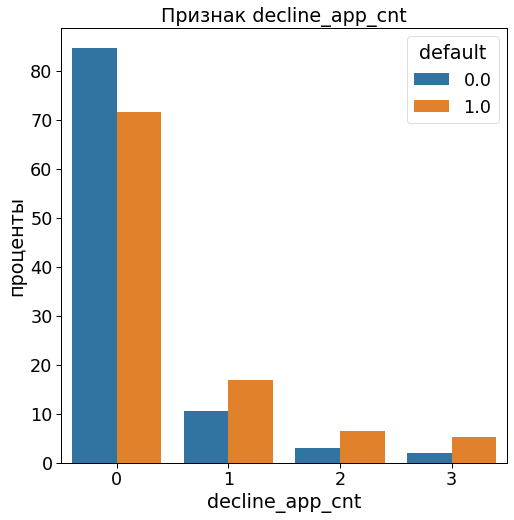

In [64]:
# Построим графики распределения значений по их соотношению с default:
for col in cat_cols:
    plt.figure(figsize=(8,8))
    prop_df = df[col].groupby(df["default"]).value_counts(
        normalize=True).rename("проценты").reset_index()
    prop_df["проценты"] *= 100
    sns.barplot(x=col, y="проценты", hue="default", data=prop_df)
    plt.title(f"Признак {col}")

Риск дефолта больше у людей со школьным образованием, обращающихся за кредитоим 2 раза и более (причем чем чаще обращаются за кредитом, тем выше риск дефолта) и имеющих хотя бы один отказ. Клиенты, берущие кредит в субботу и четверг чаще не возващают его.

<AxesSubplot:>

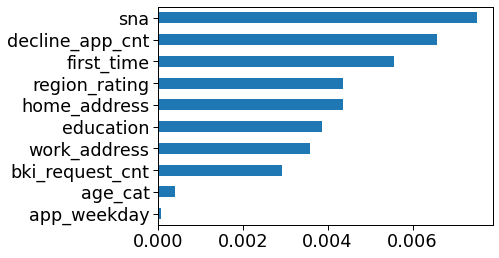

In [65]:
# Проверим значимость категориальных переменных:
temp_df = df[df['train'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[cat_cols],
                 temp_df['default'], discrete_features=True),
                 index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Самый значимый признак  - есть ли у заемщика связи с клиентами банка. Самый незначительный - день недели, когда подана заявка. 

### Построим матрицу корреляций для категориальных признаков:

<AxesSubplot:>

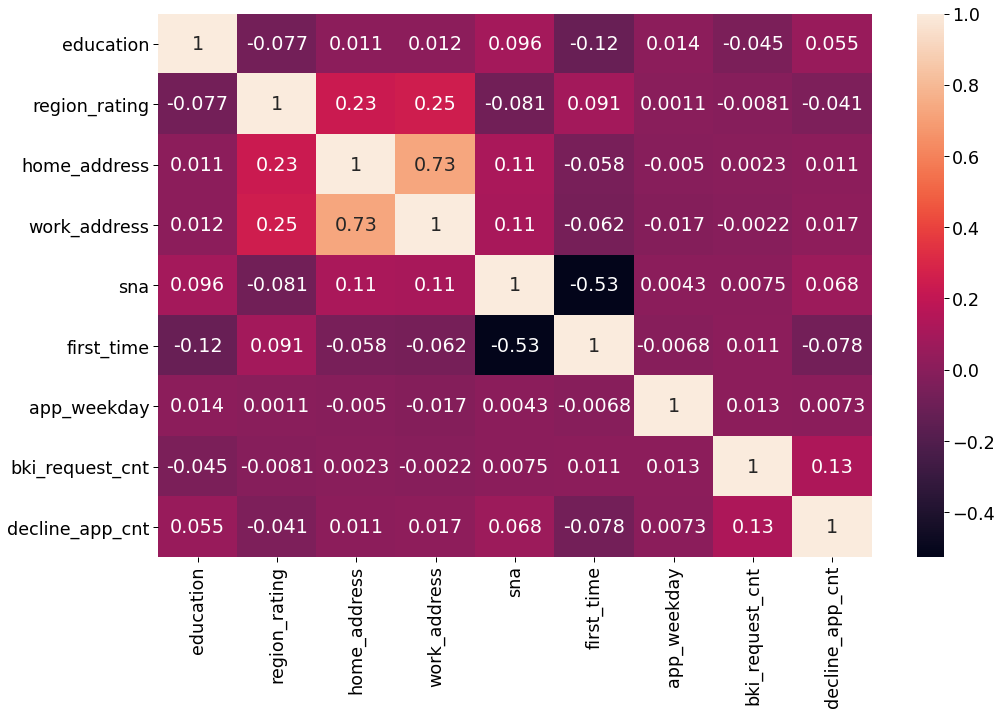

In [66]:
plt.figure(figsize=(16,10))
sns.heatmap(df[cat_cols].corr(), annot=True)

Высокая корредяция у домашнего и рабочего адресов и- прямая, и обратная у давности информации о заемщике и наличие у клиента связи с банком. По практика показала, что избавление от какого-либо из этих признаков приводит  кк худшегию модели, поэтому их трогать не будем. Категориальные признаки менять не будем, за счет числовых их количество увеличилось.

## Подготовка данных для модели

In [67]:
# Делим датасет обратно - на тест и трейн.
train = df.query('train == 1').drop(['train'], axis=1)
test = df.query('train == 0').drop(['train'], axis=1)

In [68]:
# Проверим на соответствие значений:
print('Размер тренировочного датасета: ', train.shape,
      'Размер тестового датасета: ', test.shape, sep='\n')
# Количество строк соответствует исходным.

Размер тренировочного датасета: 
(73799, 30)
Размер тестового датасета: 
(36349, 30)


In [69]:
# Выводим категориальные переменные в 0 или 1.
X_cat = \
    OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)

In [70]:
# Стандартизация числовых переменных:
X_num = StandardScaler().fit_transform(train[num_cols].values)

In [71]:
# Объединим стандартизованные числовые, полиномиальные, бинарные и закодированные категориальные переменные в одно 
# признаковое пространство,разделив при этом признаки и целевую переменную.
X = np.hstack([X_num, train[bin_cols].values, train[poly_cols].values, X_cat])
Y = train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [72]:
X.shape

(73799, 63)

## Вторая попытка обучения модели на измененных данных

In [73]:
model_2 = LogisticRegression(solver = 'liblinear', max_iter = 1000)
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)


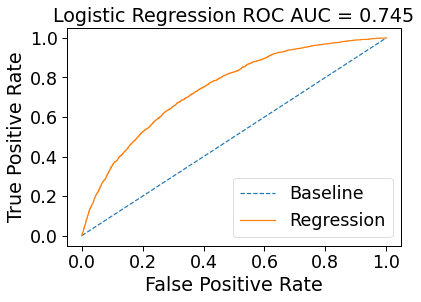

In [74]:
probs = model_2.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [75]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.875
f1_score: 0.0396
recall_score: 0.0208
MSE: 0.125


<AxesSubplot:>

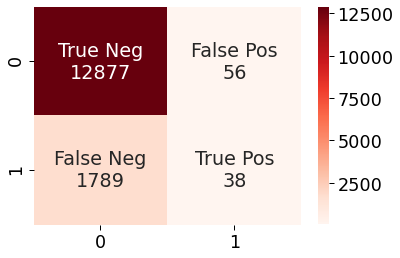

In [76]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Reds')

Результат не улучшился. Метрики даже немного ухудшились. 

## Третья  попытка. Обучение с сэмплингом (Oversampling)

В этой части делаем сразу несколько экспериментов. И посмотрим, как работает модель в зависимоти от увеличения недостающего класса.

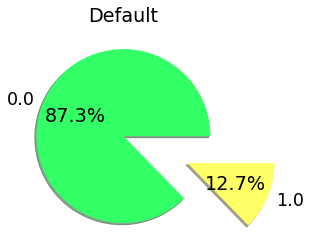

In [77]:
# Посмотрим на распределение целевого признака 'default':

default_data = df['default'].value_counts()
default_labels = list(df['default'].value_counts().index)
colors = ['#33FF66', '#FFFF66']
plt.pie(
    default_data,
    labels=default_labels,
    autopct='%1.1f%%',
    shadow=True,
    colors=colors,
    explode=[0, 0.8],
    )
plt.title('Default')
plt.show()

Клиентов c дефолтом гораздо меньше, почти в 7,5 раз. Значит необходимо сбалансировать наши выборки с дефолтом и без.

In [78]:
# Попробуем увеличить количество недостающего класса(oversampling):
default_zero = train[train['default'] == 0]
default_one = train[train['default'] == 1]
train_1 = train.append(default_one).reset_index(drop=True)
for i in range(6):
    train_1 = train_1.append(default_one).reset_index(drop=True)

In [79]:
print(train.shape)
print(train_1.shape)

(73799, 30)
(139403, 30)


In [80]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train_1[cat_cols].values)
X_num = StandardScaler().fit_transform(train_1[num_cols].values)
X = np.hstack([X_num, train_1[bin_cols].values, train_1[poly_cols].values, X_cat])
Y = train_1['default'].values

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

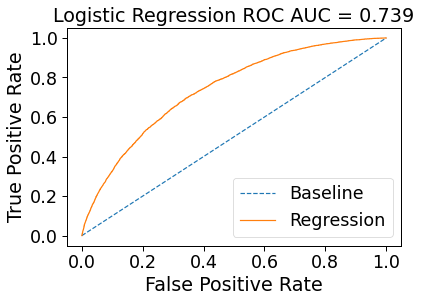

In [82]:
model_3 = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model_3.fit(X_train, y_train)
probs = model_3.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [83]:
y_pred = model_3.predict(X_test)

In [84]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.6781
f1_score: 0.7106
recall_score: 0.7339
MSE: 0.3219


<AxesSubplot:>

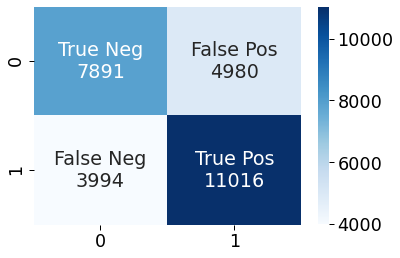

In [85]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

На трейне модель показали хорошие результаты f1 больше 0.7, но на тесте дала самые низкие показатели, поэтому использовать такую балансировку не будем.

In [86]:
# увеличим количество недостающего класса в 4 раза:
default_zero = train[train['default'] == 0]
default_one = train[train['default'] == 1]
train_1 = train.append(default_one).reset_index(drop=True)
for i in range(3):
    train_1 = train_1.append(default_one).reset_index(drop=True)

In [87]:
print(train.shape)
print(train_1.shape)

(73799, 30)
(111287, 30)


In [88]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train_1[cat_cols].values)
X_num = StandardScaler().fit_transform(train_1[num_cols].values)
X = np.hstack([X_num, train_1[bin_cols].values, train_1[poly_cols].values, X_cat])
Y = train_1['default'].values

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

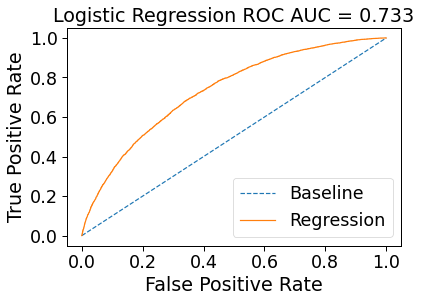

In [90]:
model_3 = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model_3.fit(X_train, y_train)
probs = model_3.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [91]:
y_pred = model_3.predict(X_test)

<AxesSubplot:>

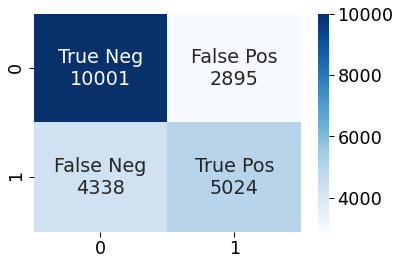

In [92]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

In [93]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.675
f1_score: 0.5814
recall_score: 0.5366
MSE: 0.325


Модель по прежнему дает неплохие результаты ( f1 = 0,58 и recall ,recall= 0.53), на тесте она также показала результаты лучше предыдущей.

Эксперименты показали, что механическое увеличение колличества строк в недостающем классе более, чем в 2 раза сильно ухудшают показатели на тесте, несмотря на неплохие метрики на трейне. Увеличим недостающий класс в 2 раза и на этой модели применим гиперпараметры.

In [94]:
default_zero = train[train['default'] == 0]
default_one = train[train['default'] == 1]
train_1 = train.append(default_one).reset_index(drop=True)

In [95]:
print(train.shape)
print(train_1.shape)

(73799, 30)
(83171, 30)


In [96]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train_1[cat_cols].values)
X_num = StandardScaler().fit_transform(train_1[num_cols].values)
X = np.hstack([X_num, train_1[bin_cols].values, train_1[poly_cols].values, X_cat])
Y = train_1['default'].values

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

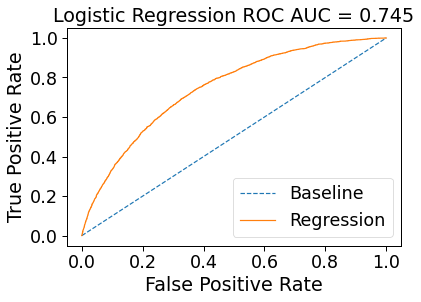

In [98]:
model_3 = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model_3.fit(X_train, y_train)
probs = model_3.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [99]:
y_pred = model_3.predict(X_test)

In [100]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.7829
f1_score: 0.2488
recall_score: 0.1583
MSE: 0.2171


<AxesSubplot:>

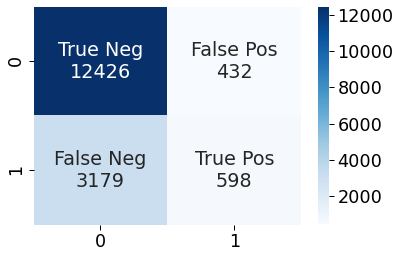

In [101]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

В отличии от остальных моделей в этом разделе метрики у неё низкие, нос использованием гиперпараметром именно эта модель дала самый высокий результат. Поэтому применим к ней гиперпараметры.

## Четвертая попытка. Гиперпараметры

In [102]:
model_4 = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=500, solver = 'liblinear', C = 100)
model_4.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', max_iter=500,
                   solver='liblinear')

In [103]:
y_pred = model_4.predict(X_test)

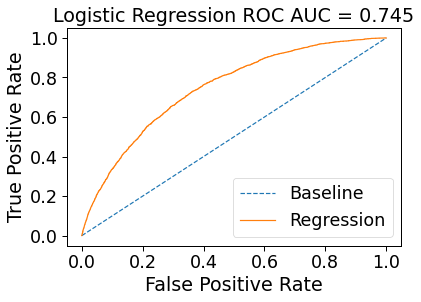

In [104]:
probs = model_4.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [105]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.6758
f1_score: 0.4918
recall_score: 0.6908
MSE: 0.3242


<AxesSubplot:>

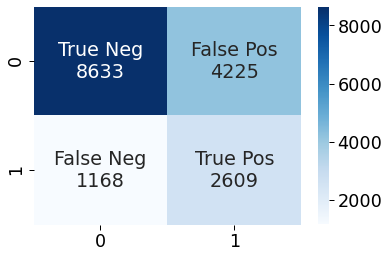

In [106]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

Последняя версия неплохо находитдефолтных клиентов, но при этом теряет много надежных. Возможно требуется дополнительные данные, такие как срок кредита, процентные ставки и сумма кредита, чтобы модель могла лучше отличать благонадежных клиентов.

## Готовим submission

In [107]:
# готовим X_num_test и X_cat_test как на трейне:
X_num_test = StandardScaler().fit_transform(test[num_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
X_test2 = np.hstack([X_num_test, test[bin_cols].values,test[poly_cols].values, X_cat_test])

In [108]:
y_probs = model_4.predict_proba(X_test2)[:,1]
y_probs.shape

(36349,)

In [109]:
#применяем модель с гиперпараметрами:
y_probs_ = model_4.predict(X_test2)
y_probs_.shape

(36349,)

In [110]:
y_probs.shape

(36349,)

In [111]:
# записываем полученные значения в целевую переменную.
test['default'] = y_probs_.astype(int)

In [112]:
#test['default'] = y_probs

In [113]:
test.sample(3)

,client_id,education,sex,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,car_dom,car_for,car_no,age_cat,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
86339,64516,4,1,1,0,1,0,-1.346712,1,80,...,1,0,0,0,1.813634,-2.677844,-5.796337,3.953858,8.558337,18.524976
95991,104533,3,1,0,0,0,0,-2.057850,0,40,...,0,0,1,0,4.234746,-4.212498,-9.764358,4.190367,9.713060,22.514381
95507,85950,1,1,1,1,0,0,-2.619437,6,40,...,0,1,0,0,6.861448,-5.292988,-11.900873,4.083063,9.180450,20.641527


In [114]:
submission = test[['client_id','default']]
display(submission.head(10))
display(submission.shape)

,client_id,default
73799,74835,0
73800,17527,1
73801,75683,0
73802,26883,0
73803,28862,0
73804,99881,1
73805,26630,1
73806,79934,0
73807,16605,0
73808,105449,0


(36349, 2)

In [115]:
# выгружаем получившийся датасет в файл
submission.to_csv('submission.csv', index=False)

In [116]:
pd.read_csv('submission.csv')

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
...,...,...
36344,83775,1
36345,106254,0
36346,81852,1
36347,1971,1


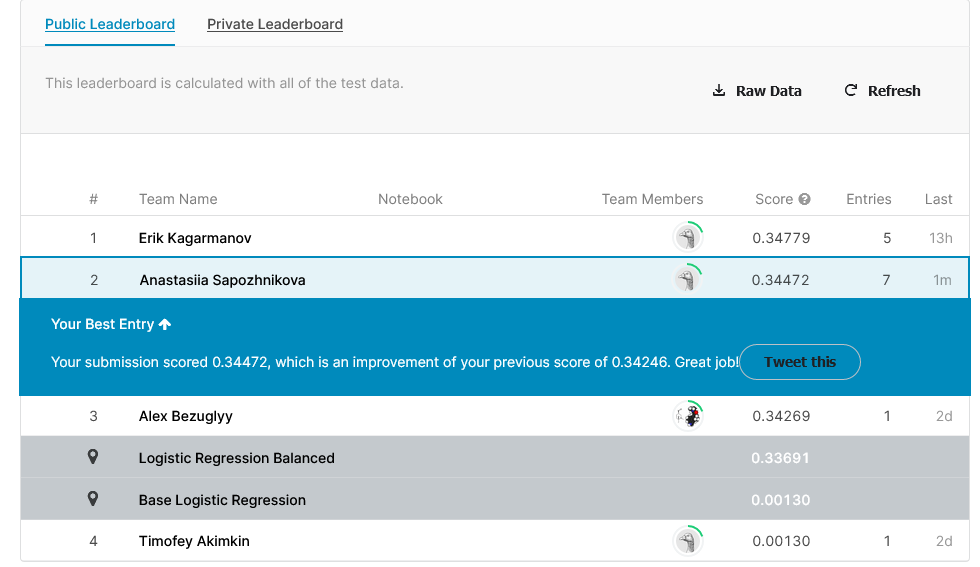

# Заключение

В данной работе представлена разработка скоринг модели для клиентов банка, определяющая вероятность их дефолта. Наилуйший показатель на тесте 0,34472. В процессе работы были изучены и  преобразованы первоначальные данные, а также созданы новые признаки. Но только после применения сэмплиенга (добавления недостающего класса путем механического дублировпания срок) значения метрик стали существенно меняться в лучшую сторону. На последнем шаге были применены гиперпараметры, которые и позволили достигнуть вышеназванного результата.
Получившаяся модель далека не идеальна, но возможно для её улучшения требуется больше информации о клиентах: семейное положение, наличие детей , годовые траты; а также информации о кредите: ставка, срок. И , конечно, требутся опыт разработчика, которого пока у меня не  хватает.
